### Chapter 17

# **응용_파이토치 이미지 인식 `얼굴로 나이 예측`**

> ## 학습목표
- 딥러닝 모델을 활용하여 입력된 얼굴 이미지를 정확히 분석하고 개인의 나이를 예측할 수 있도록 프로그래밍 할 수 있다. 
- 얼굴 이미지의 특징을 효과적으로 추출하기 위해 합성곱 신경망(CNN) 기반의 아키텍처를 설계하고 구현할 수 있다.
- 다양한 연령대와 얼굴 조건(조명, 표정, 피부색 등)에 대해 일반화된 예측 성능을 높이기 위해 데이터 증강 및 처리 기법을 적용할 수 있다.
- 모델의 학습 결과를 평가하고, 손실 함수 및 하이퍼파라미터 최적화를 통해 예측 정확도를 높일 수 있다.

## **17.1 얼굴 이미지를 입력으로 받아 나이를 예측하는 모델 구현**

### **UTKFace 데이터 세트는 0~116세의 대규모 얼굴 데이터 세트입니다.**

<img src="./image/utkface.png" width="800"/>
<figcaption>그림17.1 UTKFace Large Scale Face Dataset (출처 : https://susanqq.github.io/UTKFace/)</figcaption>

#### 데이터셋 개요

-   20,000개 이상의 다양한 얼굴 이미지 포함
-   연령대 : 0세부터 116세까지 폭넓은 분포
-   각 이미지에 나이, 성별, 인종 정보가 주석으로 제공

#### 이미지 특성

-   자연스러운 환경에서 촬영된 단일 얼굴 이미지
-   포즈, 표정, 조명, 가림, 해상도 등 다양한 변수 포함
-   정렬 및 크롭된 얼굴 이미지 버전 제공
-   68개 랜드마크 포인트 정보 포함

#### 활용 분야

-   얼굴 검출
-   나이 추정
-   나이 진행/회귀 모델링
-   얼굴 랜드마크 위치 추정

각 얼굴 이미지의 레이블은 파일 이름에 내장되어 있으며 형식은 다음과 같습니다.`[age]_[gender]_[race]_[date&time].jpg`

-   `[age]`0~116 사이의 정수로 연령을 나타냅니다.
-   `[gender]`0(남자) 또는 1(여자)입니다.
-   `[race]`0에서 4까지의 정수이며, 백인, 흑인, 아시아인, 인도인 및 기타(히스패닉계, 라틴계, 중동인 등)를 나타냅니다.
-   `[date&time]`yyyymmddHHMMSSFFF 형식으로 이미지가 UTKFace에 수집된 날짜와 시간을 표시합니다.

In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torchvision.models import resnet50, ResNet50_Weights

class UTKFaceDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.jpg')]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        try:
            image = Image.open(img_name).convert('RGB')  # 이미지를 RGB로 변환
            age = int(self.image_files[idx].split('_')[0])# 파일명에서 나이 추출
            
            if self.transform:
                image = self.transform(image)
            
            return image, age
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")
            return None

# 데이터 변환 및 정규화 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet 입력 크기에 맞게 조정
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet 통계 사용
])

# 데이터셋 로드 및 분할
dataset = UTKFaceDataset(root_dir='data/UTKface', transform=transform)
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class AgeEstimationModel(nn.Module):

    def __init__(self):
        super(AgeEstimationModel, self).__init__()
        self.resnet = resnet50(weights=ResNet50_Weights.DEFAULT)  
        # 사전 학습된 ResNet50 로드
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 1)  
        # 출력층을 1개의 노드로 변경 (나이 추정)
        
    def forward(self, x):
        return self.resnet(x)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
        
        # 검증
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
        
        val_loss /= len(val_loader.dataset)
        print(f'Validation Loss: {val_loss:.4f}')
    
    return model

# 모델, 손실 함수, 옵티마이저 초기화
model = AgeEstimationModel()
criterion = nn.MSELoss()  # 평균 제곱 오차 사용
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer)

# 학습된 모델 저장
torch.save(trained_model.state_dict(), 'age_estimation_model.pth', _use_new_zipfile_serialization=False)

def predict_age(model, image_path):
    """이미지에서 나이를 예측하는 함수"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image)
    
    predicted_age = output.item()
    return round(predicted_age)



Epoch 1/10, Loss: 248.3813
Validation Loss: 142.8384
Epoch 2/10, Loss: 122.4773
Validation Loss: 159.3572
Epoch 3/10, Loss: 95.1930
Validation Loss: 96.7725


In [1]:
# 모델 로드 및 예측
predicted_age = predict_age(model, './data/UTKface/1_0_2_20161219203249692.jpg')
print(f'예측된 나이: {predicted_age}세')

NameError: name 'predict_age' is not defined

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.font_manager as fm
from matplotlib import rcParams

# 한글 폰트 설정
rcParams['font.family'] = 'Malgun Gothic'
rcParams['axes.unicode_minus'] = False

# 폰트 설정 확인
print("현재 설정된 폰트:", rcParams['font.family'])

# 모델 로드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('age_estimation_model.pth', map_location=device))

def predict_and_display_age(model, image_path):
    """
    이미지의 나이를 예측하고 이미지와 함께 결과를 표시하는 함수
    """
    # 나이 예측
    predicted_age = predict_age(model, image_path)
    
    # 이미지 로드 및 표시
    img = Image.open(image_path)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'예측된 나이: {predicted_age}세\n실제 나이: {image_path.split("/")[-1].split("_")[0]}세')
    plt.show()
    
    return predicted_age

# 모델 로드 및 예측
image_path = './data/UTKface/36_1_1_20170109141849605.jpg'
predicted_age = predict_and_display_age(model, image_path)
print(f'예측된 나이: {predicted_age}세')

# 80_1_0_20170110140603775
# 54_0_0_20170111210520573
# 42_0_2_20170104184350086
# 36_1_1_20170109141849605


## **17.2 Korean Face Age Classification**

**■ 데이터 소개**

총 1,000 가계 (3,000명)이상을 대상으로 80,700장
(가족사진 : 6,900, 각도별 개인 사진 : 49,800, 기간별 나이 사진 : 24,000) 이상의 가족 관계 얼굴 이미지 데이터셋을 구축


**■ 구축목적**

– 가계도 내 가족 관계 정보 데이터셋을 구축함으로써 가족 내 안면 유사도를 추출할 수 있으며, 가족 관계 관련 산업에 활용이 가능함

– 총 1,000 가계 이상의 직계 가족 구성원에 대한 안면 데이터를 획득, 정제, 가공하여 경찰청 등의 국가 관리 사업 뿐 아니라, 응용 기술 및 관련 산업 분야의 성장을 도모함 

– 가계도 내 인물의 기간별 안면 데이터셋을 구축함으로써 인물 나이 추정이 가능하여 범죄자 나이 예측 등에 다향한 분야로 활용 가능함


## **`한국인 얼굴이 주어졌을 때 나이(age)를 예측하는 인공지능`**

#### **데이터 세트 소개**

* 전체 데이터 세트는 13,068개의 이미지로 구성된다.

<pre>
F0001_AGE_D_18_a1.jpg
F0001_AGE_D_18_a2.jpg
...
F0900_AGE_M_57_f1.jpg
F0900_AGE_M_57_f2.jpg
</pre>



<img src="image/facedataset.png" width="600px">


* <b>custom_dataset.csv</b>는 각 이미지에 대한 <b>메타 정보</b>를 가진다.
  * 속성(attribute) 목록: 'family_id', 'person_id', 'age_class', 'image_path'

* 전체 이미지를 학습(training), 검증(validation), 테스트(test) 목적으로 나눈다.
  * 학습 데이터 세트: (F0001 ~ F0299) folders have 10,025 images.
  * 검증 데이터 세트: (F0801 ~ F0850) folders have 1,539 images.
  * 테스트 데이터 세트: (F0851 ~ F0900) folders have 1,504 images.

* 본 저장소에서는 각 <b>이미지</b>와 <b>나이 정보(age class)</b>만 사용한다.
  * 주어진 한 장의 한국인 얼굴 이미지가 어떠한 나이군에 해당하는지 예측하는 작업을 수행한다.

* <b>데이터 세트 다운로드</b>: 
  * 본 데이터 세트는 [AI Hub "가족 관계가 알려진 얼굴 이미지 데이터 세트"](https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=528)를 활용한다.

  
  <img width="800" height="" src="./image/family.png" >

#### 최종 테스트 결과
<img src="image/faceresult.png" width="200px">

출처 : https://github.com/ndb796/korean_face_age_dataset

## **17.3 Korean Face Age Classification 실습**

In [1]:
!git clone https://github.com/ndb796/korean_face_age_dataset

fatal: destination path 'korean_face_age_dataset' already exists and is not an empty directory.


### 라이브러리 불러오기

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
import matplotlib.image as image
import numpy as np
import pandas as pd
from PIL import Image
import os

### 데이터 세트 불러오기
- Reference: https://github.com/ndb796/korean_face_age_classification 

* 데이터 세트를 확인한다.
  * <b>Training dataset</b>: (F0001 ~ F0299) folders have 10,025 images.
  * <b>Validation dataset</b>: (F0801 ~ F0850) folders have 1,539 images.
  * <b>Test dataset</b>: (F0851 ~ F0900) folders have 1,504 images.

In [3]:
def parsing(meta_data):     
    # meta_data를 처리하여 이미지와 나이 클래스에 대한 정보를 추출하는 함수
    image_age_list = []     # 이미지 경로와 나이 클래스를 저장할 빈 리스트 생성
    # 메타데이터 파일의 모든 행을 순차적으로 처리
    for idx, row in meta_data.iterrows():
        image_path = row['image_path']   # 현재 행에서 이미지 경로 가져오기
        age_class = row['age_class']     # 현재 행에서 나이 클래스 가져오기
        image_age_list.append([image_path, age_class])   
        # 이미지 경로와 나이 클래스를 리스트에 추가
    return image_age_list    # 결과 리스트 반환

PyTorch의 Dataset 클래스를 상속받은 사용자 정의 데이터셋 클래스를 구현한 것입니다.
나이 클래스 레이블을 다루는 데이터셋을 처리합니다.

In [4]:
class Dataset(Dataset):
    def __init__(self, meta_data, image_directory, transform=None):
        self.meta_data = meta_data  # 메타 데이터 (각 이미지에 대한 정보)
        self.image_directory = image_directory  # 이미지가 저장된 디렉토리 경로
        self.transform = transform  # 이미지 변환 (예: 데이터 증강 등)
        
# 메타 데이터를 처리하는 함수 (meta_data에서 나이 클래스와 이미지 경로를 추출)
        image_age_list = parsing(meta_data)
        self.image_age_list = image_age_list 
        # 나이 클래스와 이미지 경로를 담고 있는 리스트

        # 나이 클래스에서 레이블로 변환하는 매핑
        self.age_class_to_label = {
            "a": 0, "b": 1, "c": 2, "d": 3, "e": 4, "f": 5, "g": 6, "h": 7
        }

    def __len__(self):   #__len__ 메서드는 데이터셋의 크기를 반환
        return len(self.meta_data)   
    # meta_data의 길이를 반환하여 데이터셋의 크기를 알 수 있음
        
    def __getitem__(self, idx):
        image_path, age_class = self.image_age_list[idx]   
        # 해당 인덱스의 이미지 경로와 나이 클래스 추출
        img = Image.open(os.path.join(self.image_directory, image_path))   
        # 이미지 파일을 열기
        label = self.age_class_to_label[age_class]   
        # 나이 클래스를 레이블로 변환

        if self.transform:
            img = self.transform(img)  # 변환 함수가 지정되면 이미지를 변환
    
        return img, label  # 이미지와 레이블 반환

__getitem__ 메서드는 데이터셋에서 특정 인덱스에 해당하는 이미지와 레이블을 반환합니다.
image_age_list[idx]를 통해 해당 인덱스에 있는 이미지 파일 경로와 나이 클래스(문자)를 얻습니다.
Image.open을 사용해 이미지를 열고, age_class_to_label 딕셔너리를 사용하여 나이 클래스 문자열을 숫자 레이블로 변환합니다.
만약 transform이 제공되었다면 이미지를 변환합니다.
마지막으로 이미지와 해당 레이블을 튜플로 반환합니다.

In [5]:
label_to_age = {
    0: "0-6 years old",
    1: "7-12 years old",
    2: "13-19 years old",
    3: "20-30 years old",
    4: "31-45 years old",
    5: "46-55 years old",
    6: "56-66 years old",
    7: "67-80 years old"
}

# CSV 파일 경로를 저장
train_meta_data_path = "korean_face_age_dataset/custom_train_dataset.csv"
train_meta_data = pd.read_csv(train_meta_data_path)
train_image_directory = "korean_face_age_dataset/train_images"

val_meta_data_path = "korean_face_age_dataset/custom_val_dataset.csv"
val_meta_data = pd.read_csv(val_meta_data_path)
val_image_directory = "korean_face_age_dataset/val_images"

test_meta_data_path = "korean_face_age_dataset/custom_test_dataset.csv"
test_meta_data = pd.read_csv(test_meta_data_path)
test_image_directory = "korean_face_age_dataset/test_images"

train_transform = transforms.Compose([
    transforms.Resize(128),             # 이미지를 128x128 크기로 리사이즈
    transforms.RandomHorizontalFlip(),  # 이미지를 랜덤하게 좌우 반전(Flip)
    transforms.ToTensor(),              # 텐서 형식으로 변환
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # RGB 채널에 대한 평균과 표준편차 값
])

val_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

# Dataset 객체 생성: 학습용 메타데이터, 이미지 디렉터리, 변환을 인자로 받음
train_dataset = Dataset(train_meta_data, train_image_directory, train_transform)

# DataLoader 객체 생성: 배치 크기 32로 설정하고, 데이터 셔플을 활성화하여 학습 데이터를 로딩
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = Dataset(val_meta_data, val_image_directory, val_transform)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = Dataset(test_meta_data, test_image_directory, test_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

- 이미지는 보통 [0, 255] 범위의 정수 값으로 표현되지만, ToTensor()는 이를 [0.0, 1.0] 범위의 실수로 변환합니다.
- 이미지는 (H, W, C) 형태로 되어있을 수 있는데, ToTensor()는 이를 (C, H, W)로 변환합니다. (C는 채널, H는 높이, W는 너비)
- 각 채널에 대해 (image - mean) / std 형태로 정규화가 이루어 집니다.
- 정규화하는 이유는 모델이 다양한 입력값 범위를 보다 안정적으로 학습할 수 있도록 돕기 위해서입니다.

위 코드는 이미지를 128x128 크기로 리사이즈하고, 랜덤하게 좌우 반전을 적용한 뒤, PyTorch Tensor로 변환하고, 마지막으로 각 RGB 채널을 평균 0.5, 표준편차 0.5로 정규화하는 작업을 수행합니다. 이 과정은 이미지 데이터를 딥러닝 모델에 적합한 형태로 전처리하는 데 사용됩니다.

### <b>데이터 시각화(Data Visualization)</b>

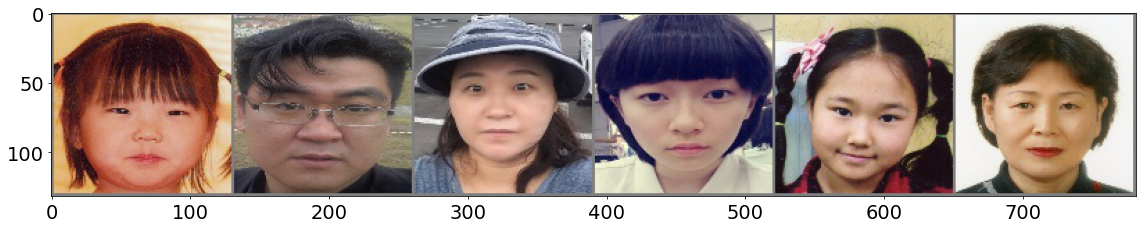

['0-6 years old', '46-55 years old', '31-45 years old', '13-19 years old', '7-12 years old', '46-55 years old']


In [6]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['figure.dpi'] = 70
plt.rcParams.update({'font.size': 20})


def imshow(input):
    # torch.Tensor => numpy 변환 (채널, 높이, 너비 형식에서 높이, 너비, 채널 형식으로 변환)
    input = input.numpy().transpose((1, 2, 0))
    
    # 이미지 정규화 되돌리기 (이미지의 평균과 표준편차를 사용하여 원본 값 복원)
    mean = np.array([0.5, 0.5, 0.5])  # 각 채널에 대한 평균 값
    std = np.array([0.5, 0.5, 0.5])   # 각 채널에 대한 표준편차 값
    input = std * input + mean    
    # 정규화된 이미지를 복원하기 위해 표준편차와 평균을 되돌림
    
    # 이미지 값이 0과 1 사이로 제한되도록 클리핑 
    # (픽셀 값이 0보다 작거나 1보다 크지 않도록)
    input = np.clip(input, 0, 1)
    
    plt.imshow(input)
    plt.show()


# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
imgs, labels = next(iterator)
out = torchvision.utils.make_grid(imgs[:6])
imshow(out)
print([label_to_age[labels[i].item()] for i in range(6)])

### 딥러닝 모델 학습

- ResNet-50 모델을 생성하는 코드입니다. ResNet-50은 50개의 층을 가진 딥러닝 모델로, 주로 이미지 분류 작업에 사용됩니다.
- pretrained=True: pretrained=True는 모델이 ImageNet 데이터셋으로 미리 학습된 가중치를 로드하도록 지정하는 옵션입니다. 즉, 이 모델은 이미 ImageNet 데이터셋을 기반으로 학습된 상태에서 로드되며, 이를 "전이 학습"이라고 합니다.
- 이렇게 미리 학습된 모델을 사용하면, 동일한 종류의 이미지 분류 문제를 해결할 때 학습을 더 빨리 진행할 수 있습니다.

In [7]:
learning_rate = 0.01
log_step = 20

# ResNet-50 모델을 생성. ResNet-50은 50개의 층을 가진 딥러닝 모델로, 주로 이미지 분류 작업에 사용
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 전이 학습을 위한 마지막 레이어 수정
# 모델의 마지막 fully connected (fc) 레이어를 새로운 nn.Linear 레이어로 교체
# num_features는 모델의 이전 레이어에서 출력된 특성의 개수, 8은 새로운 출력 클래스의 수 (예: 8개의 클래스 분류)
model.fc = nn.Linear(num_features, 8) 
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

c:\Users\ASUS\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


train()함수는 주어진 훈련 데이터에 대해 모델을 훈련시키며, 각 배치마다 손실과 정확도를 누적하고, 주어진 간격마다 현재 훈련 상태를 출력합니다. 에포크가 끝나면 최종 훈련 손실과 정확도를 출력하고, 훈련이 끝난 후에는 평균 손실과 정확도를 반환합니다.

In [8]:
import time

epoch=0

def train():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')
    model.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(train_dataloader):  
        #훈련 데이터 로더에서 배치 단위로 데이터를 가져옵니다. 
        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)     
        #모델에 이미지를 입력하고 예측 결과(outputs)를 얻습니다.
        optimizer.zero_grad()
        
        # 모델의 출력(outputs)에서 클래스별 확률이 가장 높은 값을 선택하여 
        # 예측 클래스(preds)를 추출
        _, preds = torch.max(outputs, 1)   
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        total += labels.shape[0] # 배치에서 처리한 샘플의 수를 누적, 샘플의 개수
        running_loss += loss.item() # 배치 손실을 누적, Python 숫자로 변환
        
    # 예측한 값(preds)과 실제 레이블(labels.data)이 일치하는 샘플의 수를 누적
        running_corrects += torch.sum(preds == labels.data)
        
        
        # 특정 배치마다 훈련 상태를 출력합니다. 
        # log_step은 훈련 상태를 출력할 간격을 설정하는 변수로, 
        # 예를 들어 10으로 설정하면 10번째 배치마다 출력됩니다.
        if i % log_step == log_step - 1:
            
            # 훈련 손실과 훈련 정확도를 출력합니다. 
            # 손실은 누적 손실을 총 샘플 수로 나눈 값이고, 
            # 정확도는 예측이 맞은 샘플 수를 총 샘플 수로 나눈 값입니다.
            print(f'[Batch: {i + 1}] running train loss: {running_loss / total}, running train accuracy: {running_corrects / total}')
    
    print(f'train loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

In [9]:
import time

def validate():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Validation]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(val_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running val loss: {running_loss / total}, running val accuracy: {running_corrects / total}')

    print(f'val loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()


def test():
    start_time = time.time()
    print(f'[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(test_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

In [10]:
# 학습률 초기화 (예시: 0.001로 설정)
learning_rate = 0.001

# 학습률 조정 함수
def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 3:    
        lr /= 10      # 3번째 epoch 이후 학습률을 10배 감소
    if epoch >= 7:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr     # optimizer의 학습률을 업데이트

In [11]:
num_epochs = 10
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []

# for epoch in range(num_epochs): num_epochs만큼 반복하면서 훈련을 진행합니다. 
# epoch는 현재 훈련의 에포크 번호를 나타내며, 0부터 num_epochs-1까지 반복됩니다.
for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))

    if val_acc > best_val_acc:
        print("[Info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f'best_checkpoint_epoch_{epoch + 1}.pth')

torch.save(model.state_dict(), f'last_checkpoint_epoch_{num_epochs}.pth')

[Epoch: 1 - Training]
[Batch: 20] running train loss: 0.059119926765561104, running train accuracy: 0.2562499940395355
[Batch: 40] running train loss: 0.05509739760309458, running train accuracy: 0.32343751192092896
[Batch: 60] running train loss: 0.05257969982922077, running train accuracy: 0.35625001788139343
[Batch: 80] running train loss: 0.05043170140124857, running train accuracy: 0.38007813692092896
[Batch: 100] running train loss: 0.04898385807871818, running train accuracy: 0.3931249976158142
[Batch: 120] running train loss: 0.04742148431638877, running train accuracy: 0.41041669249534607
[Batch: 140] running train loss: 0.04637405308229583, running train accuracy: 0.42053571343421936
[Batch: 160] running train loss: 0.04519691274035722, running train accuracy: 0.43535158038139343
[Batch: 180] running train loss: 0.044297978685547905, running train accuracy: 0.4428819417953491
[Batch: 200] running train loss: 0.04340264435857535, running train accuracy: 0.45531249046325684
[Ba

### <b>학습 결과 확인하기</b>

* 학습 결과를 시각화하여 정상적으로 모델이 학습되었는지 확인한다.

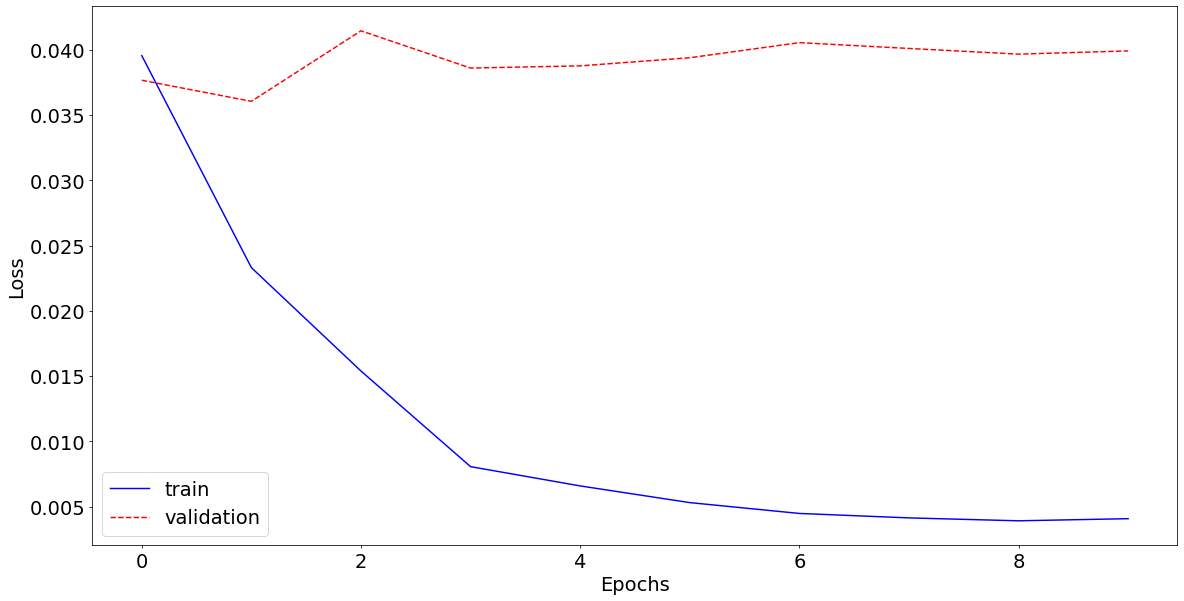

In [12]:
plt.plot([x[0] for x in history], 'b', label='train')
plt.plot([x[1] for x in history], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

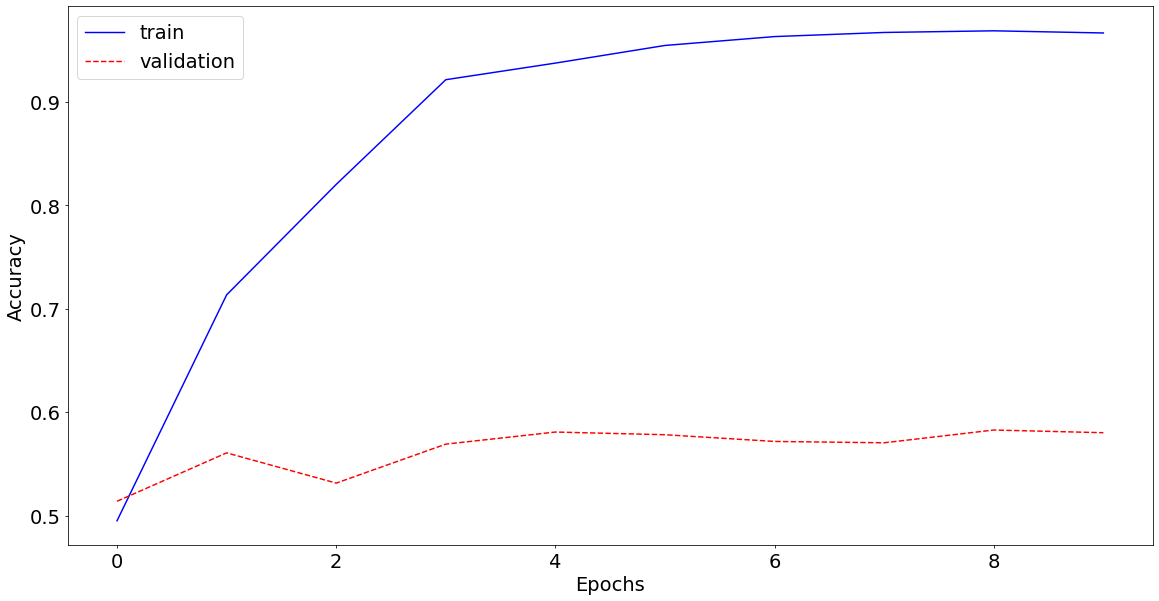

In [13]:
plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
model = models.resnet50(pretrained=True)   
# 사전 학습된 ResNet50 모델을 불러옵니다 
# pretrained=True를 설정하면, ImageNet 데이터셋에서 학습된 가중치를 가져옵니다.

num_features = model.fc.in_features
# model.fc는 ResNet50의 마지막 fully connected (fc) layer입니다. in_features는 이 fc layer로 들어오는 입력의 특징 수(즉, 뉴런 수)를 반환합니다. ResNet50의 경우 2048개의 특징이 입력됩니다.

model.fc = nn.Linear(num_features, 8) # transfer learning
# model.fc를 새로 정의하여, 8개의 클래스로 분류하는 문제에 맞게 출력 뉴런 수를 8로 설정합니다. 즉, 모델의 출력이 8개의 클래스로 분류될 수 있도록 변경한 것입니다.

model = model.cuda()
# 모델을 GPU로 옮깁니다. cuda()는 모델을 GPU 메모리로 이동시키는 함수로, GPU에서 학습을 진행할 수 있게 해줍니다. 만약 GPU를 사용하지 않는다면 model = model.to('cpu')와 같이 수정할 수 있습니다.

model_path = 'best_checkpoint_epoch_6.pth'
# 'best_checkpoint_epoch_9.pth' 경로에서 저장된 모델 가중치를 불러옵니다. 이 파일에는 모델의 학습된 가중치가 저장되어 있으며, 이를 model.load_state_dict() 함수를 통해 모델에 적용합니다.

# weights_only=True 옵션을 사용하여 모델 가중치 로드
model.load_state_dict(torch.load(model_path, weights_only=True))

# 테스트 수행 및 결과 출력
test_loss, test_accuracy = test()
print(f"Test loss: {test_loss:.8f}")
print(f"Test accuracy: {test_accuracy * 100.:.2f}%")

[Test]
[Batch: 1] running test loss: 0.03982238844037056, running test accuracy: 0.625
[Batch: 20] running test loss: 0.04194784294813871, running test accuracy: 0.6109375357627869
[Batch: 40] running test loss: 0.03949754084460437, running test accuracy: 0.632031261920929
test loss: 0.03898082709217325, accuracy: 0.6336435675621033
elapsed time: 15.45942211151123
Test loss: 0.03898083
Test accuracy: 63.36%


### **■ PTH 파일?**

- best_checkpoint_epoch_**X**.pth 파일은 일반적으로 모델 학습 과정에서 특정 에폭(epoch)에서 가장 좋은 성능을 보인 모델의 가중치를 저장하기 위해 만들어집니다. 

- 이 파일은 모델의 체크포인트를 저장하여 이후에 모델을 다시 로드하고 평가할 수 있게 합니다. 

- 이를 통해 모델을 처음부터 학습시키지 않고도 가장 좋은 성능을 보였던 모델 상태를 복원할 수 있습니다.


**1) 모델 체크포인트(Storage of Model Checkpoints)** : 머신 러닝 및 딥 러닝 모델 학습 시, 일정한 주기나 조건에서 현재 모델의 상태(가중치, 옵티마이저 상태 등)를 저장합니다. 

- 이를 체크포인트라고 합니다. 이를 통해 학습이 중단된 경우에도 다시 이어서 학습할 수 있으며, 나중에 성능을 비교하거나 검토할 수 있습니다.

- 베스트 모델 저장(Saving the Best Model): 학습 중에 모델의 성능이 평가 지표(예: 검증 데이터셋의 정확도, 손실 등)에 따라 주기적으로 평가됩니다. 

- 특정 에폭에서 모델이 가장 높은 성능을 보이면 해당 에폭의 모델을 "베스트 모델"로 저장할 수 있습니다. 

- best_checkpoint_epoch_X.pth는 모델이 가장 좋은 성능을 보인 시점, 예를 들어 X번째 에폭의 모델 가중치를 저장한 파일입니다.

**2) 실습 예시(Pseudocode Example)** : 모델 학습 코드를 작성할 때, 일반적으로 다음과 같은 로직으로 모델의 체크포인트를 저장합니다:

- 따라서, best_checkpoint_epoch_X.pth 파일이 생기는 이유는 X번째 에폭에서 모델이 가장 좋은 성능을 보였고, 해당 시점의 모델 가중치를 저장했기 때문입니다. 이를 통해 나중에 이 모델을 불러와서 테스트하거나 이어서 학습할 수 있습니다.

In [15]:
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/ERolmAUw4N5PhhTCyxlERNUB1mDSGZ7GI8KFi80r2aQNlg?download=1 -O saved_best_checkpoint_epoch_8.pth
    

In [16]:
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 8) # transfer learning
model = model.cuda()
model_path = 'best_checkpoint_epoch_6.pth'
model.load_state_dict(torch.load(model_path))

test_loss, test_acc = test()
print("test loss:", test_loss)
print("test acc:", test_acc)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_4284\1093692003.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


[Test]
[Batch: 1] running test loss: 0.03982238844037056, running test accuracy: 0.625
[Batch: 20] running test loss: 0.04194784294813871, running test accuracy: 0.6109375357627869
[Batch: 40] running test loss: 0.03949754084460437, running test accuracy: 0.632031261920929
test loss: 0.03898082709217325, accuracy: 0.6336435675621033
elapsed time: 4.210748910903931
test loss: 0.03898082709217325
test acc: 0.6336435675621033


-----

## **17.4 Korean Face Age Classificatio 클론 코딩**

#### <b>Download the Dataset</b>

In [17]:
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EbMhBPnmIb5MutZvGicPKggBWKm5hLs0iwKfGW7_TwQIKg?download=1 -O custom_korean_family_dataset_resolution_128.zip
!unzip custom_korean_family_dataset_resolution_128.zip -d ./custom_korean_family_dataset_resolution_128

#### <b>Load Libraries</b>

In [18]:
import os
import time
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import transforms, models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

#### <b>Load Datasets</b>

* <b>Training dataset</b>: (F0001 ~ F0299) folders have 10,025 images.
* <b>Validation dataset</b>: (F0801 ~ F0850) folders have 1,539 images.
* <b>Test dataset</b>: (F0851 ~ F0900) folders have 1,504 images.

In [19]:
def parsing(meta_data):
    image_age_list = []
    # iterate all rows in the metadata file
    for idx, row in meta_data.iterrows():
        image_path = row['image_path']
        age_class = row['age_class']
        image_age_list.append([image_path, age_class])
    return image_age_list

In [20]:
class Dataset(Dataset):
    def __init__(self, meta_data, image_directory, transform=None):
        self.meta_data = meta_data
        self.image_directory = image_directory
        self.transform = transform

        # process the meta data
        image_age_list = parsing(meta_data)

        self.image_age_list = image_age_list
        self.age_class_to_label = {
            "a": 0, "b": 1, "c": 2, "d": 3, "e": 4, "f": 5, "g": 6, "h": 7
        }

    def __len__(self):
        return len(self.meta_data)
            
    def __getitem__(self, idx):
        image_path, age_class = self.image_age_list[idx]
        img = Image.open(os.path.join(self.image_directory, image_path))
        label = self.age_class_to_label[age_class]

        if self.transform:
            img = self.transform(img)
        
        return img, label

In [21]:
label_to_age = {
    0: "0-6 years old",
    1: "7-12 years old",
    2: "13-19 years old",
    3: "20-30 years old",
    4: "31-45 years old",
    5: "46-55 years old",
    6: "56-66 years old",
    7: "67-80 years old"
}

# CSV 파일 경로를 저장
train_meta_data_path = "korean_face_age_dataset/custom_train_dataset.csv"
train_meta_data = pd.read_csv(train_meta_data_path)
train_image_directory = "korean_face_age_dataset/train_images"

val_meta_data_path = "korean_face_age_dataset/custom_val_dataset.csv"
val_meta_data = pd.read_csv(val_meta_data_path)
val_image_directory = "korean_face_age_dataset/val_images"

test_meta_data_path = "korean_face_age_dataset/custom_test_dataset.csv"
test_meta_data = pd.read_csv(test_meta_data_path)
test_image_directory = "korean_face_age_dataset/test_images"

train_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

val_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

train_dataset = Dataset(train_meta_data, train_image_directory, train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)

val_dataset = Dataset(val_meta_data, val_image_directory, val_transform)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)

test_dataset = Dataset(test_meta_data, test_image_directory, test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

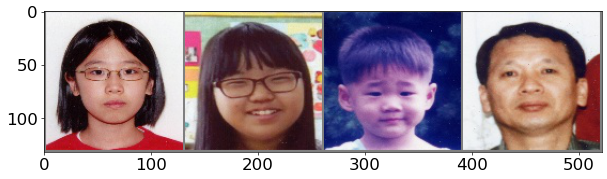

['13-19 years old', '13-19 years old', '0-6 years old', '46-55 years old']


In [32]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.show()


# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
imgs, labels = next(iterator)
out = torchvision.utils.make_grid(imgs[:4])
imshow(out)
print([label_to_age[labels[i].item()] for i in range(4)]) # 1: family, 0: not family